## Dropout is best !!!!111!1!1!

In [3]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from fashion import FashionMNIST

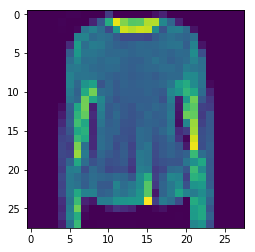

In [4]:
train_data = FashionMNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = FashionMNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))


train_idx = np.random.choice(train_data.data.shape[0], 54000, replace=False)

train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]

mask = np.ones(60000)
mask[train_idx] = 0

valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]

batch_size = 100
test_batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=False, transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

validation_data = {}
loss_train_data = {}
loss_validation_data = {}

plt.imshow(train_loader.dataset.data[1].numpy()) #Potentially printing out an image

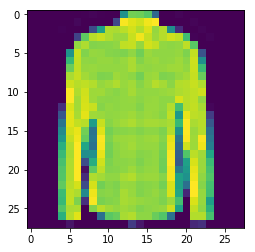

In [6]:
plt.imshow(train_loader.dataset.data[10].numpy()) # another image

#### Modèle 1: FCC sans dropout

In [7]:
class FccWithoutDropout(nn.Module):
    def __init__(self, model_id, input_size, hidden_sizes, output_size, activation_function):
        super().__init__()
        self.model_id = model_id
        self.activation_function = activation_function
        self.inputToHidden = nn.Linear(input_size, hidden_sizes[0]) #Linear(D, M)
        self.hiddenToHidden = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hiddenToHidden.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.hiddenToOutput = nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size) #Linear(M, K)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = self.activation_function(self.inputToHidden(x))
        for f in self.hiddenToHidden:
            x = self.activation_function(f(x))
        x = F.log_softmax(self.hiddenToOutput(x), dim=1)
        return x

#### Modèle 2: FCC avec dropout

In [8]:
class FccWithDropout(nn.Module):
    def __init__(self, model_id, input_size, hidden_sizes, output_size, activation_function, dropout):
        super().__init__()
        self.model_id = model_id
        self.activation_function = activation_function
        self.inputToHidden = nn.Linear(input_size, hidden_sizes[0]) #Linear(D, M)
        self.hiddenToHidden = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hiddenToHidden.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.hiddenToOutput = nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size) #Linear(M, K)
        self.dropout = dropout
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = self.activation_function(self.dropout(self.inputToHidden(x)))
        for f in self.hiddenToHidden:
            x = self.activation_function(self.dropout(f(x)))
        x = F.log_softmax(self.dropout(self.hiddenToOutput(x)), dim=1)
        return x

#### Modèle 3: CNN sans dropout

In [9]:
class SimpleCnnWithoutDropout(nn.Module): #taken from https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/
    #Our batch shape for input x is (1, 28, 28)
    
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 25, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(25 * 14 * 14, 256)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (1, 28, 28) to (25, 28, 28)
        x = F.relu(self.conv1(x))
        
        #Size changes from (25, 28, 28) to (25, 14, 14)
        x = self.pool(x)
       
        #Reshape data to input to the input layer of the neural net
        #Size changes from (25, 14, 14) to (1, 4900)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 25 * 14 *14)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4900) to (1, 256)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 256) to (1, 10)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return(x)

#### Modèle 4: CNN avec dropout

In [10]:
class SimpleCnnWithDropout(nn.Module): #taken from https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/
    #Our batch shape for input x is (1, 28, 28)
    
    def __init__(self, model_id, dropout):
        super().__init__()
        self.model_id = model_id
        self.dropout = dropout
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 25, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(25 * 14 * 14, 256)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (1, 28, 28) to (25, 28, 28)
        x = F.relu(self.dropout(self.conv1(x)))
        
        #Size changes from (25, 28, 28) to (25, 14, 14)
        x = self.pool(x)
       
        #Reshape data to input to the input layer of the neural net
        #Size changes from (25, 14, 14) to (1, 4900)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 25 * 14 *14)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4900) to (1, 256)
        x = F.relu(self.dropout(self.fc1(x)))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 256) to (1, 10)
        x = self.fc2(x)
        x = F.log_softmax(self.dropout(x), dim = 1)
        return(x)

#### Modèle 5: VGG sans dropout

#### Modèle 6: VGG avec dropout

#### Modèle 7: Inception V3 sans dropout

#### Modèle 8: Inception V3 avec dropout

#### Modèle 9: Resnet sans dropout

#### Modèle 10: Resnet avec dropout

#### Entraînement

In [11]:
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += F.nll_loss(output, target, size_average=False).item()

    total_loss /= len(train_loader.dataset)
    loss_train_data[model.model_id].append(total_loss)

    return model

#### Validation

In [12]:
def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(valid_loader.dataset)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    loss_validation_data[model.model_id].append(valid_loss)
    return 1.0 * correct.item() / len(valid_loader.dataset) 

#### Test

In [13]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

#### Expérimentation

In [14]:
def experiment(model, epochs=10, lr=0.001):
    best_precision = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)
    validation_data[model.model_id] = []
    loss_validation_data[model.model_id]= []
    loss_train_data[model.model_id] = []
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        precision = valid(model, validation_loader)
        validation_data[model.model_id].append(precision)
        if precision > best_precision:
            best_precision = precision
            best_model = model
    return best_model, best_precision

#### Définition des modèles utilisés

In [18]:
halfDropout = nn.Dropout(0.5)
fifthDropout = nn.Dropout(0.2)

fcc = FccWithoutDropout("fcc",28*28, [512], 10, F.sigmoid)
fccHalfDropout = FccWithDropout("fcc_d.5",28*28, [512], 10, F.sigmoid, halfDropout)
fccFifthDropout = FccWithDropout("fcc_d.2",28*28, [512], 10, F.sigmoid, fifthDropout)
cnn = SimpleCnnWithoutDropout("cnn")
cnnHalfDropout = SimpleCnnWithDropout("cnn_d.5", halfDropout)
cnnFifthDropout = SimpleCnnWithDropout("cnn_d.2", fifthDropout)

models = [
          fcc, 
          fccHalfDropout, 
          fccFifthDropout,
          cnn,
          cnnHalfDropout,
          cnnFifthDropout
         ]

#### main

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  



valid set: Average loss: 0.4299, Accuracy: 8468/10000 (84%)


valid set: Average loss: 0.4255, Accuracy: 8407/10000 (84%)


valid set: Average loss: 0.3661, Accuracy: 8696/10000 (86%)


valid set: Average loss: 0.3470, Accuracy: 8785/10000 (87%)


valid set: Average loss: 0.3483, Accuracy: 8731/10000 (87%)


valid set: Average loss: 0.3360, Accuracy: 8793/10000 (87%)


valid set: Average loss: 0.3626, Accuracy: 8668/10000 (86%)


valid set: Average loss: 0.3209, Accuracy: 8837/10000 (88%)


valid set: Average loss: 0.3198, Accuracy: 8845/10000 (88%)


valid set: Average loss: 0.3351, Accuracy: 8801/10000 (88%)

final precision for model  fcc  is  0.8845

valid set: Average loss: 0.4946, Accuracy: 8213/10000 (82%)


valid set: Average loss: 0.4697, Accuracy: 8347/10000 (83%)


valid set: Average loss: 0.4862, Accuracy: 8336/10000 (83%)


valid set: Average loss: 0.4382, Accuracy: 8488/10000 (84%)


valid set: Average loss: 0.4462, Accuracy: 8450/10000 (84%)


valid set: Average loss: 0

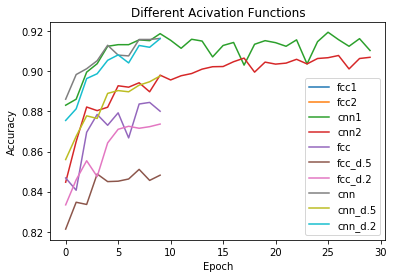

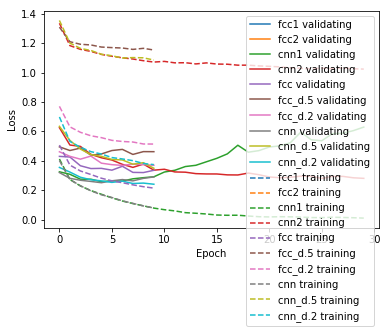

In [19]:
best_precision = 0
for model in models:
    model.cuda()  # if you have access to a gpu
    model, precision = experiment(model, epochs=10)
    print("final precision for model ", model.model_id, " is ", precision)
    if precision > best_precision:
        best_precision = precision
        best_model = model

test(best_model, test_loader)
print("The best model is: " + best_model.model_id)
for i, data in validation_data.items():
    plt.plot(data, label = i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Different Acivation Functions")
plt.show()

for i, data in loss_validation_data.items():
    plt.plot(data, label = i+" validating")
for i, data in loss_train_data.items():
    plt.plot(data, label = i+" training", linestyle = '--')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()